In [1]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [2]:
!kaggle datasets download "vipoooool/new-plant-diseases-dataset"


100% 2.69G/2.70G [00:12<00:00, 197MB/s]
100% 2.70G/2.70G [00:12<00:00, 234MB/s]
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 594, in _terminate_pool
    worker_handler.join()
  File "/usr/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


In [3]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
train_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(224, 224),
  batch_size=32)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

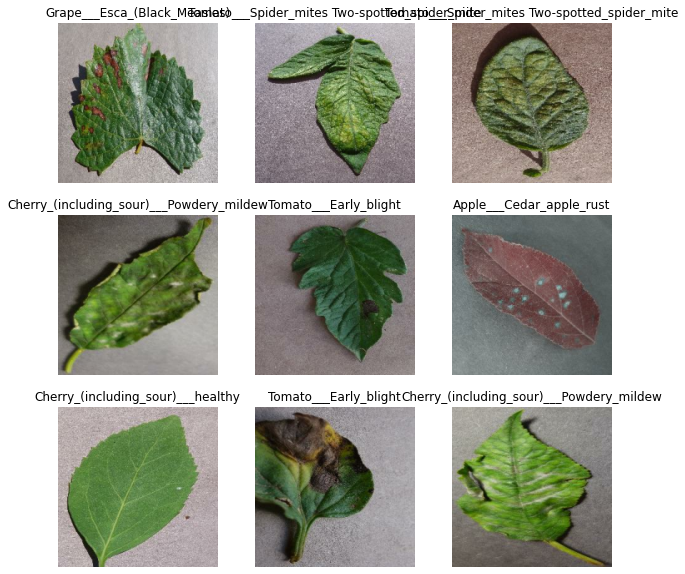

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [10]:
# AUTOTUNE = tf.data.AUTOTUNE
# 
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96324563


In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [13]:
model = Sequential([
    
    layers.Conv2D(32,(3,3),activation="relu",padding="same",input_shape=(224,224,3)),
    layers.MaxPooling2D(3,3),

    layers.Conv2D(64,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D(3,3),

    layers.Conv2D(128,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D(3,3),

    layers.Conv2D(256,(3,3),activation="relu",padding="same"),
    layers.MaxPooling2D(3,3),
                          
    layers.Conv2D(512,(3,3),activation="relu",padding="same"),
                          
    layers.Flatten(),
    layers.Dense(1024,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(38,activation="softmax")
])

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=7,
  verbose=1
)

Epoch 1/7
2197/2197 [==============================] - 179s 76ms/step - loss: 1.3453 - accuracy: 0.6147 - val_loss: 0.7078 - val_accuracy: 0.7765
Epoch 2/7
2197/2197 [==============================] - 138s 63ms/step - loss: 0.5908 - accuracy: 0.8201 - val_loss: 0.4465 - val_accuracy: 0.8596
Epoch 3/7
2197/2197 [==============================] - 123s 56ms/step - loss: 0.4818 - accuracy: 0.8554 - val_loss: 0.4168 - val_accuracy: 0.8697
Epoch 4/7
2197/2197 [==============================] - 121s 55ms/step - loss: 0.4071 - accuracy: 0.8769 - val_loss: 0.5120 - val_accuracy: 0.8507
Epoch 5/7
2197/2197 [==============================] - 121s 55ms/step - loss: 0.3797 - accuracy: 0.8846 - val_loss: 0.4321 - val_accuracy: 0.8690
Epoch 6/7
2197/2197 [==============================] - 120s 55ms/step - loss: 0.3544 - accuracy: 0.8948 - val_loss: 0.3355 - val_accuracy: 0.8981
Epoch 7/7
2197/2197 [==============================] - 121s 55ms/step - loss: 0.3387 - accuracy: 0.8992 - val_loss: 0.4151 -

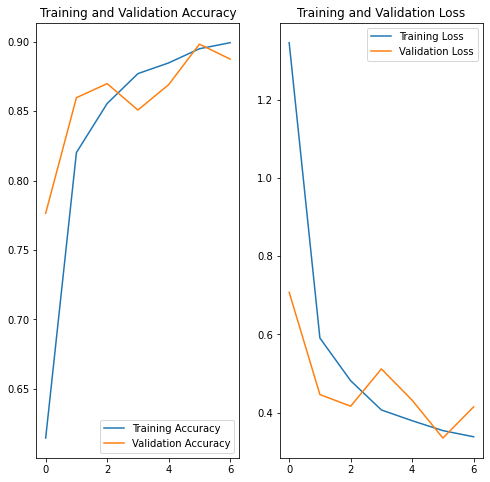

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

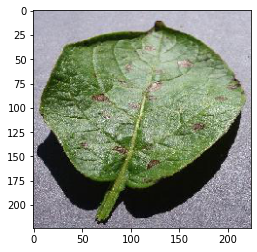

/content/test/test/PotatoEarlyBlight5.JPG
Potato___Early_blight


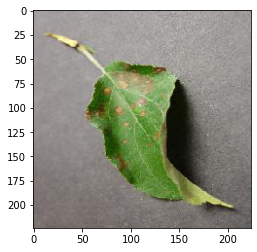

/content/test/test/AppleCedarRust3.JPG
Apple___Cedar_apple_rust


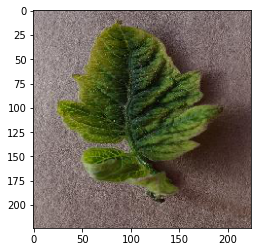

/content/test/test/TomatoYellowCurlVirus1.JPG
Tomato___Spider_mites Two-spotted_spider_mite


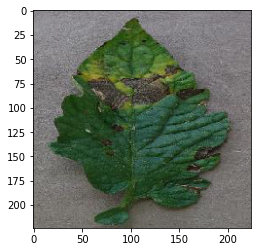

/content/test/test/TomatoEarlyBlight4.JPG
Tomato___Early_blight


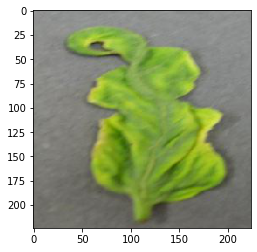

/content/test/test/TomatoYellowCurlVirus5.JPG
Tomato___Tomato_Yellow_Leaf_Curl_Virus


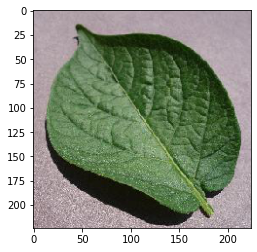

/content/test/test/PotatoHealthy1.JPG
Apple___healthy


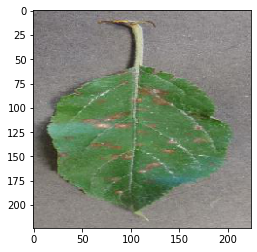

/content/test/test/AppleCedarRust2.JPG
Apple___Cedar_apple_rust


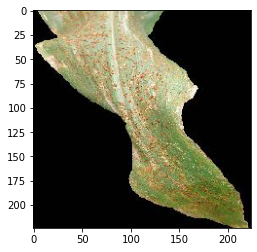

/content/test/test/CornCommonRust3.JPG
Corn_(maize)___Common_rust_


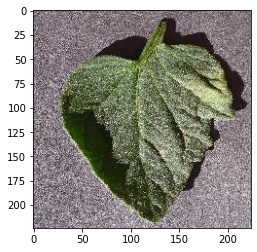

/content/test/test/TomatoHealthy1.JPG
Tomato___healthy


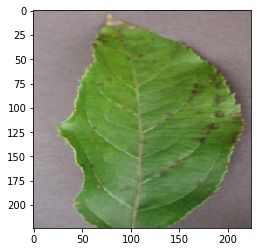

/content/test/test/AppleScab1.JPG
Apple___Apple_scab


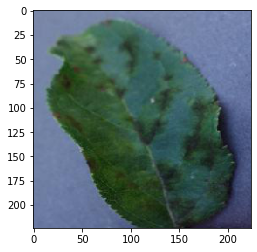

/content/test/test/AppleScab2.JPG
Apple___Apple_scab


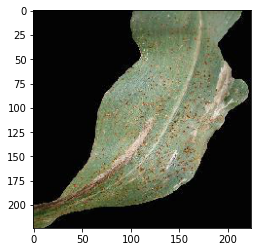

/content/test/test/CornCommonRust1.JPG
Corn_(maize)___Common_rust_


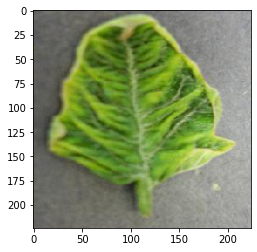

/content/test/test/TomatoYellowCurlVirus6.JPG
Tomato___Tomato_Yellow_Leaf_Curl_Virus


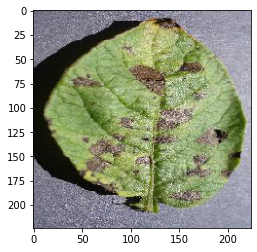

/content/test/test/PotatoEarlyBlight2.JPG
Potato___Early_blight


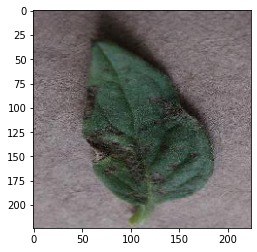

/content/test/test/TomatoEarlyBlight6.JPG
Tomato___Target_Spot


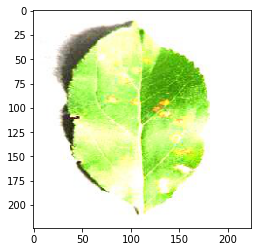

/content/test/test/AppleCedarRust1.JPG
Apple___Cedar_apple_rust


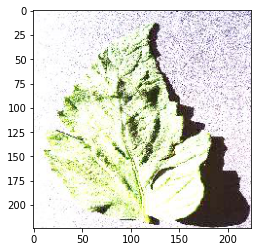

/content/test/test/TomatoHealthy4.JPG
Tomato___healthy


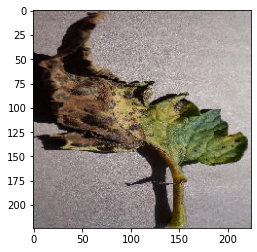

/content/test/test/TomatoEarlyBlight1.JPG
Peach___healthy


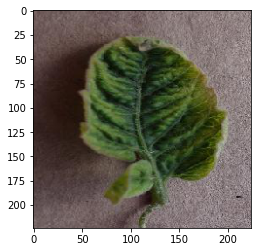

/content/test/test/TomatoYellowCurlVirus2.JPG
Tomato___Tomato_Yellow_Leaf_Curl_Virus


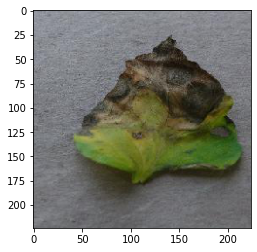

/content/test/test/TomatoEarlyBlight2.JPG
Tomato___Septoria_leaf_spot


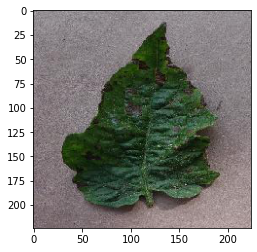

/content/test/test/TomatoEarlyBlight3.JPG
Tomato___Spider_mites Two-spotted_spider_mite


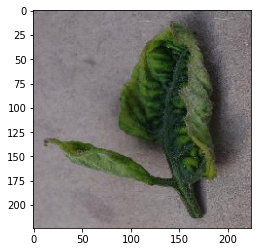

/content/test/test/TomatoYellowCurlVirus3.JPG
Tomato___Tomato_Yellow_Leaf_Curl_Virus


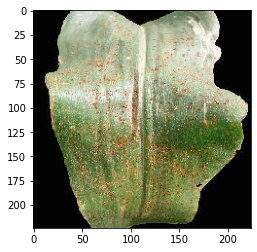

/content/test/test/CornCommonRust2.JPG
Corn_(maize)___Common_rust_


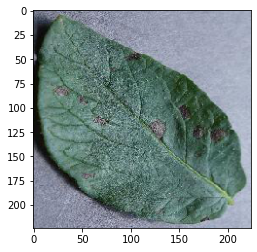

/content/test/test/PotatoEarlyBlight3.JPG
Apple___healthy


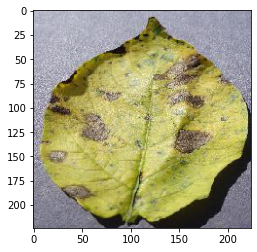

/content/test/test/PotatoEarlyBlight4.JPG
Potato___Early_blight


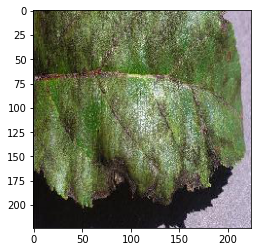

/content/test/test/AppleScab3.JPG
Strawberry___Leaf_scorch


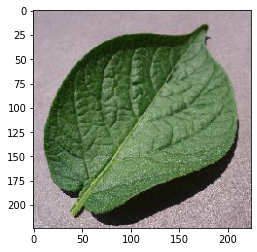

/content/test/test/PotatoHealthy2.JPG
Potato___healthy


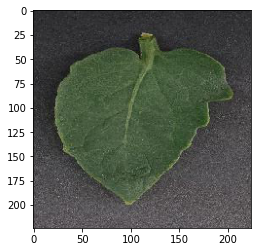

/content/test/test/TomatoHealthy2.JPG
Apple___healthy


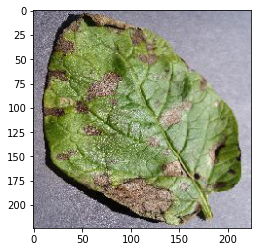

/content/test/test/PotatoEarlyBlight1.JPG
Potato___Early_blight


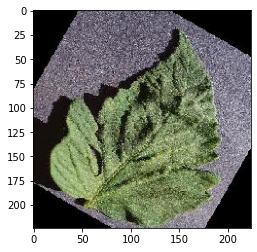

/content/test/test/TomatoHealthy3.JPG
Tomato___healthy


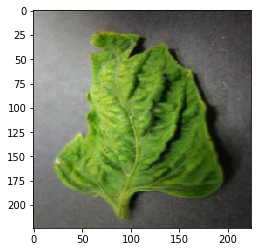

/content/test/test/TomatoYellowCurlVirus4.JPG
Raspberry___healthy


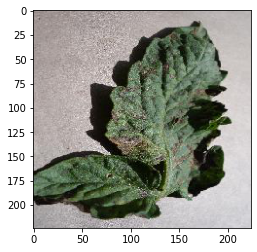

/content/test/test/TomatoEarlyBlight5.JPG
Peach___healthy


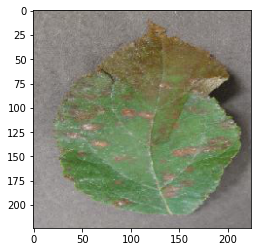

/content/test/test/AppleCedarRust4.JPG
Apple___Cedar_apple_rust


In [17]:
from keras.preprocessing import image
import os

test_dir = '/content/test/test'
for i in os.listdir(test_dir):
    img = image.load_img(test_dir + '/' + i, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(test_dir + '/' + i)
    print(class_names[np.argmax(classes)])

### Export Model 
Simpan dan export model dalam bentuk SavedModel

In [18]:
PLANT_DESEASE_SAVED_MODEL = "exp_saved_model"

In [19]:
tf.saved_model.save(model, PLANT_DESEASE_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [20]:
%%bash -s $PLANT_DESEASE_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['conv2d_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_conv2d_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 38)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
# !zip -r /content/exp_saved_model.zip /content/exp_saved_model
# files.download('/content/exp_saved_model.zip')


In [30]:
loaded = tf.saved_model.load(PLANT_DESEASE_SAVED_MODEL)

In [31]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='conv2d_input')})
{'dense_1': TensorSpec(shape=(None, 38), dtype=tf.float32, name='dense_1')}


### Convert SavedModel ke TFLite 
Gunakan TFLiteConverter dengan SavedModel


In [39]:
def representative_data_gen():
  for image_batch, labels_batch in valid_ds:
    yield [image_batch]

In [ ]:
# test_ds = tf.keras.utils.image_dataset_from_directory(
#   test_dir,
#   image_size=(224, 224))
# 
# def representative_dataset_gen():
#   for _ in range(10):
#     pfad='/content/test/test/AppleCedarRust1.JPG'
#     img = image.load_img(pfad)
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0).astype(np.float32) 
#     # Get sample input data as a numpy array in a method of your choosing.
#     yield [img]
# 
# converter.representative_dataset = representative_data_gen

In [40]:
converter = tf.lite.TFLiteConverter.from_saved_model(PLANT_DESEASE_SAVED_MODEL)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

In [41]:
tflite_model_file = 'PLANT_DESEASE_CONVERTED_MODEL.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(quantized_tflite_model)